In [3]:
import torch
print(torch.cuda.is_available)

<function is_available at 0x000002AB24387240>


In [1]:
# =============================================================================
# COMPLETE FRESH START – Schizophrenia EEG Detection (MSU Dataset)
# =============================================================================

# Cell 1: Install all required packages
# %pip install -q mne PyWavelets scikit-image tensorflow torchvision torchaudio scikit-learn seaborn matplotlib joblib

import numpy as np
import os
import mne
from scipy.signal import butter, filtfilt
import pywt
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
import torch
from torchvision import models, transforms
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from joblib import dump

print("Setup complete.")

c:\Users\soumi\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\soumi\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\soumi\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framewo

Setup complete.


In [12]:
# Cell 2: Download & Unzip MSU Dataset
import os
import urllib.request
import zipfile

os.makedirs('msu_data/norm', exist_ok=True)
os.makedirs('msu_data/sch', exist_ok=True)

def download_and_unzip(url, out_zip, dest_dir):
    if not os.path.exists(out_zip):
        print(f"Downloading {out_zip}...")
        urllib.request.urlretrieve(url, out_zip)
    else:
        print(f"{out_zip} already exists, skipping download.")

    print(f"Extracting {out_zip} to {dest_dir}...")
    with zipfile.ZipFile(out_zip, 'r') as zf:
        zf.extractall(dest_dir)

download_and_unzip(
    'http://brain.bio.msu.ru/eeg_data/schizophrenia/norm.zip',
    'norm.zip',
    'msu_data/norm'
)

download_and_unzip(
    'http://brain.bio.msu.ru/eeg_data/schizophrenia/sch.zip',
    'sch.zip',
    'msu_data/sch'
)

print('Done.')

Extracting norm.zip to msu_data/norm...
Extracting sch.zip to msu_data/sch...
Done.


In [2]:
# Cell 3: Load EEG Data (.eea files)
def load_subject(file_path, n_ch=16, n_samples=7680):
    try:
        data = np.loadtxt(file_path, dtype=np.float32)
        if len(data) != n_ch * n_samples:
            print(f"Warning: {os.path.basename(file_path)} size mismatch ({len(data)} vs {n_ch*n_samples})")
        return data.reshape(n_ch, n_samples)
    except Exception as e:
        print(f"Load error {file_path}: {e}")
        return None

data_list = []
labels = []

# Healthy (norm)
norm_files = sorted([f for f in os.listdir('msu_data/norm') if f.endswith('.eea')])
print(f"Found {len(norm_files)} healthy files")
for f in norm_files:
    eeg = load_subject(f'msu_data/norm/{f}')
    if eeg is not None:
        data_list.append(eeg)
        labels.append(0)

# Schizo (sch)
sch_files = sorted([f for f in os.listdir('msu_data/sch') if f.endswith('.eea')])
print(f"Found {len(sch_files)} schizo files")
for f in sch_files:
    eeg = load_subject(f'msu_data/sch/{f}')
    if eeg is not None:
        data_list.append(eeg)
        labels.append(1)

msu_data = np.array(data_list)
msu_labels = np.array(labels)

print(f"Loaded {msu_data.shape[0]} subjects, shape {msu_data.shape}")
print(f"Labels: {np.bincount(msu_labels)} (healthy / schizo)")

Found 18 healthy files
Found 18 schizo files
Loaded 36 subjects, shape (36, 16, 7680)
Labels: [18 18] (healthy / schizo)


In [3]:
# Cell 4: Preprocessing – Filter + Re-reference
fs = 128
ch_names = ['F7','F3','F4','F8','T3','C3','Cz','C4','T4','T5','P3','Pz','P4','T6','O1','O2']
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types='eeg')

def bandpass(data, low, high, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, data, axis=-1)

# Combined range (0.5 to 45 Hz) instead of iterative destruction
low_cut = 0.5
high_cut = 45

preprocessed = np.zeros_like(msu_data, dtype=np.float32)
for i in range(msu_data.shape[0]):
    subj = msu_data[i]
    # Filter the raw data just once
    subj = bandpass(subj, low_cut, high_cut, fs)
    
    # MNE Object creation
    raw = mne.io.RawArray(subj, info)
    raw.set_eeg_reference('average', projection=True)
    
    # Extract data back
    preprocessed[i] = raw.get_data()

print("Preprocessing done.")

Creating RawArray with float64 data, n_channels=16, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Creating RawArray with float64 data, n_channels=16, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Creating RawArray with float64 data, n_channels=16, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has no

In [6]:
# MERGED CELL 5 & 6: Generate Scalograms AND Extract Features on-the-fly
# This prevents RAM from exploding by discarding images after use.

import gc # Garbage collector interface

# ... (Include your setup for models: eff_extractor, den_extractor, etc. here) ...

eff_all = []
den_all = []

print("Starting streamlined processing...")

for subj_i in range(len(preprocessed)):
    # Temporary storage for this ONE subject
    eff_ch_mean = []
    den_ch_mean = []
    
    # Process all 16 channels for this subject
    for ch in range(16):
        # 1. GENERATE SCALOGRAMS (Just for this channel)
        # ------------------------------------------------
        signal = preprocessed[subj_i, ch]
        # Copy your make_scalogram logic here or call the function
        # (Assuming make_scalogram is defined as in your previous code)
        ch_imgs = make_scalogram(signal) 
        
        if len(ch_imgs) == 0:
            eff_ch_mean.append(np.zeros(1536))
            den_ch_mean.append(np.zeros(1664))
            continue

        # 2. EXTRACT FEATURES (Immediately)
        # ------------------------------------------------
        
        # EfficientNet Feature Extraction
        # Convert grayscale to RGB by repeating channels (saves RAM vs storing RGB)
        eff_input = np.repeat(ch_imgs, 3, axis=-1) 
        eff_input = preprocess_input(eff_input)
        eff_f = eff_extractor.predict(eff_input, verbose=0)
        eff_ch_mean.append(np.mean(eff_f, 0))

        # DenseNet Feature Extraction
        den_f = []
        with torch.no_grad():
            for im in ch_imgs:
                # Convert to RGB tensor on the fly
                im_rgb = np.repeat(im, 3, axis=-1)
                im_t = torch_transform(im_rgb).unsqueeze(0).to(device)
                fm = den_extractor(im_t)
                p = adaptive_pool(fm)
                feat = p.view(1, -1).cpu().numpy()[0]
                den_f.append(feat)
        den_ch_mean.append(np.mean(den_f, 0) if den_f else np.zeros(1664))
        
        # 3. CLEANUP (Crucial!)
        # ------------------------------------------------
        del ch_imgs     # Delete the images from RAM
        del eff_input   # Delete the processed batch
        # Python's garbage collector will reclaim this memory

    # Store the averaged features for this subject
    eff_all.append(np.mean(eff_ch_mean, 0))
    den_all.append(np.mean(den_ch_mean, 0))
    
    # Force garbage collection every subject to keep RAM flat
    gc.collect() 
    print(f"Subject {subj_i+1}/{len(preprocessed)} done. RAM should be stable.")

# Combine features at the very end
features = np.hstack([np.array(eff_all), np.array(den_all)])
print(f"Features shape: {features.shape}")
np.save('features.npy', features)

Starting streamlined processing...
Subject 1/36 done. RAM should be stable.
Subject 2/36 done. RAM should be stable.
Subject 3/36 done. RAM should be stable.
Subject 4/36 done. RAM should be stable.
Subject 5/36 done. RAM should be stable.
Subject 6/36 done. RAM should be stable.
Subject 7/36 done. RAM should be stable.
Subject 8/36 done. RAM should be stable.
Subject 9/36 done. RAM should be stable.
Subject 10/36 done. RAM should be stable.
Subject 11/36 done. RAM should be stable.
Subject 12/36 done. RAM should be stable.
Subject 13/36 done. RAM should be stable.
Subject 14/36 done. RAM should be stable.
Subject 15/36 done. RAM should be stable.
Subject 16/36 done. RAM should be stable.
Subject 17/36 done. RAM should be stable.
Subject 18/36 done. RAM should be stable.
Subject 19/36 done. RAM should be stable.
Subject 20/36 done. RAM should be stable.
Subject 21/36 done. RAM should be stable.
Subject 22/36 done. RAM should be stable.
Subject 23/36 done. RAM should be stable.
Subject 

Classes: [18 18]
Best params: {'C': 10, 'gamma': 'scale'}
CV acc: 0.8678571428571429
Test acc: 0.875
              precision    recall  f1-score   support

     Healthy       1.00      0.75      0.86         4
      Schizo       0.80      1.00      0.89         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8



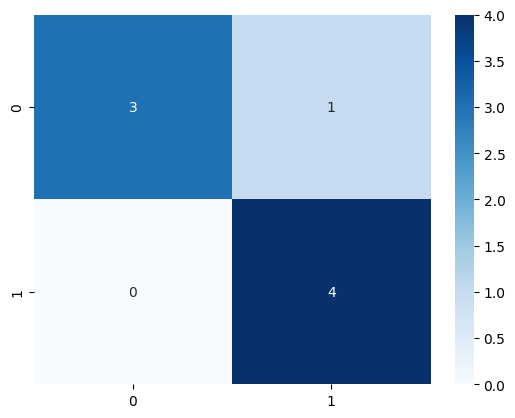

In [7]:
# Cell 7: Classification
n = len(features)
labels = msu_labels[:n]

if len(np.unique(labels)) < 2:
    print("ERROR: Only one class! Need both healthy and schizo subjects.")
else:
    print("Classes:", np.bincount(labels))

    selector = SelectKBest(mutual_info_classif, k=100)
    X_sel = selector.fit_transform(features, labels)

    param_grid = {'C': [1, 10, 50], 'gamma': ['scale', 0.01]}
    grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
    grid.fit(X_sel, labels)

    print("Best params:", grid.best_params_)
    print("CV acc:", grid.best_score_)

    X_tr, X_te, y_tr, y_te = train_test_split(X_sel, labels, test_size=0.2, stratify=labels, random_state=42)
    clf = grid.best_estimator_
    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_te)

    print("Test acc:", accuracy_score(y_te, pred))
    print(classification_report(y_te, pred, target_names=['Healthy','Schizo']))

    sns.heatmap(confusion_matrix(y_te, pred), annot=True, fmt='d', cmap='Blues')
    plt.show()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 159MB/s]
